# UE 803: Data Science
## Project: Clustering and Classifying People based on Text and KB information
*05 April 2021*

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
Corpus = pd.read_csv('export_dataframe.csv')
del Corpus['Unnamed: 0']
Corpus.head()

name item_id wikipedia_title  \
0  Eldar Qasımov  Q12010   Eldar_Gasimov   
1    Nigar Jamal  Q12012     Nigar_Jamal   
2     Beth Ditto  Q12827      Beth_Ditto   
3     Willy Moon  Q14042      Willy_Moon   
4           Moby  Q14045            Moby   

                                      wikipedia_page  \
0  Eldar "Ell" Parviz oglu Gasimov (Azerbaijani: ...   
1  Nigar Aydin qizi Jamal (née Mutallibzadeh, Aze...   
2  Mary Beth Patterson (born February 19, 1981), ...   
3  William George Sinclair (born 2 June 1989), be...   
4  Richard Melville Hall (born September 11, 1965...   

                                wikidata_description     cat type  \
0                                 Azerbaijani singer  singer    a   
1                                 Azerbaijani singer  singer    a   
2                         American singer-songwriter  singer    a   
3                               New Zealand musician  singer    a   
4  American musician, singer, songwriter, produce...  singer    a   

                                preprocess_wikipedia  \
0  eldar `` ell '' parviz oglu gasimov ( azerbaij...   
1  nigar aydin qizi jamal ( née mutallibzadeh , a...   
2  mary beth patterson ( born february 19 , 1981 ...   
3  william george sinclair ( born 2 june 1989 ) ,...   
4  richard melville hall ( born september 11 , 19...   

                                 preprocess_wikidata  
0                                 azerbaijani singer  
1                                 azerbaijani singer  
2                         american singer-songwriter  
3                               new zealand musician  
4  american musician , singer , songwriter , prod...

In [3]:
#function to calcul the scors and the confusion matrix 
def acprf_classification(predictions, Test_y, labels, classif):
    cm = (confusion_matrix(predictions, Test_Y)*100)
    plot_acprf(cm, labels, predictions, classif)

In [4]:
#function to plot the confusion matrix
def plot_acprf(cm, target_names, predictions, classif, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    precision = precision_score(predictions, Test_Y, average=classif)*100
    f1 = f1_score(predictions, Test_Y, average=classif)*100
    recall = recall_score(predictions, Test_Y, average=classif)*100

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}\nF1 = {}\nRecall = {}\nprecision = {} '.format(accuracy, misclass, f1, recall, precision))
    plt.show()
    

### some additional preprocessing 

In [5]:
# Step - a : Remove blank rows if any.
Corpus['preprocess_wikipedia'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['preprocess_wikipedia'] = [entry.lower() for entry in Corpus['preprocess_wikipedia']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['preprocess_wikipedia']= [word_tokenize(entry) for entry in Corpus['preprocess_wikipedia']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['preprocess_wikipedia']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

### Two class classification

In [6]:
Corpus.head()

name item_id wikipedia_title  \
0  Eldar Qasımov  Q12010   Eldar_Gasimov   
1    Nigar Jamal  Q12012     Nigar_Jamal   
2     Beth Ditto  Q12827      Beth_Ditto   
3     Willy Moon  Q14042      Willy_Moon   
4           Moby  Q14045            Moby   

                                      wikipedia_page  \
0  Eldar "Ell" Parviz oglu Gasimov (Azerbaijani: ...   
1  Nigar Aydin qizi Jamal (née Mutallibzadeh, Aze...   
2  Mary Beth Patterson (born February 19, 1981), ...   
3  William George Sinclair (born 2 June 1989), be...   
4  Richard Melville Hall (born September 11, 1965...   

                                wikidata_description     cat type  \
0                                 Azerbaijani singer  singer    a   
1                                 Azerbaijani singer  singer    a   
2                         American singer-songwriter  singer    a   
3                               New Zealand musician  singer    a   
4  American musician, singer, songwriter, produce...  singer    a   

                                preprocess_wikipedia  \
0  [eldar, ``, ell, ``, parviz, oglu, gasimov, (,...   
1  [nigar, aydin, qizi, jamal, (, née, mutallibza...   
2  [mary, beth, patterson, (, born, february, 19,...   
3  [william, george, sinclair, (, born, 2, june, ...   
4  [richard, melville, hall, (, born, september, ...   

                                 preprocess_wikidata  \
0                                 azerbaijani singer   
1                                 azerbaijani singer   
2                         american singer-songwriter   
3                               new zealand musician   
4  american musician , singer , songwriter , prod...   

                                          text_final  
0  ['eldar', 'ell', 'parviz', 'oglu', 'gasimov', ...  
1  ['nigar', 'aydin', 'qizi', 'jamal', 'née', 'mu...  
2  ['mary', 'beth', 'patterson', 'born', 'februar...  
3  ['william', 'george', 'sinclair', 'born', 'jun...  
4  ['richard', 'melville', 'hall', 'born', 'septe...

In [7]:
#training and test data 
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['type'],test_size=0.3)

In [8]:
#encoding the labels to digits 
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [9]:
#vectorization of the corpus Tf-idf
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [10]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_svm_2 = SVM.predict(Test_X_Tfidf)

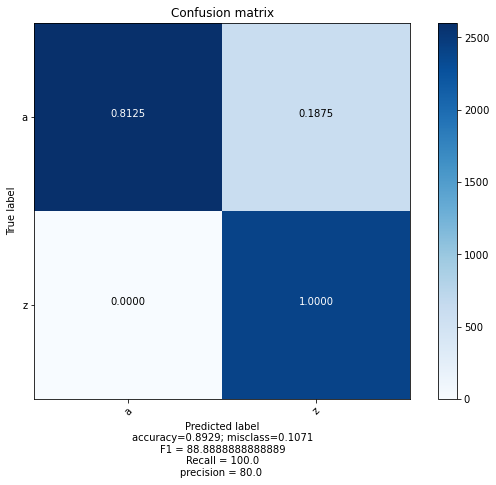

In [11]:
acprf_classification(predictions_svm_2, Test_Y, ['a', 'z'], 'binary')

### 6 class classification 

In [12]:
#training and test data 
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['cat'],test_size=0.3)

In [13]:
#encoding the labels to digits 
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [14]:
#vectorization of the corpus Tf-idf
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [15]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_svm_3 = SVM.predict(Test_X_Tfidf)

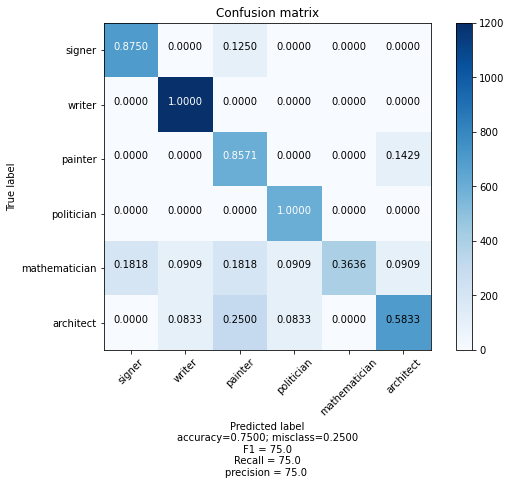

In [16]:
acprf_classification(predictions_svm_3, Test_Y, ['signer', 'writer', 'painter', 'politician', 'mathematician', 'architect'], 'micro')